## Imports

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from io_f import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from py_indoor_loc.plot import plot_floor_map
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass

In [3]:
from compute_f import compute_stride_length, compute_step_positions, compute_steps
from py_indoor_loc.pdr import filter_headings, detect_turn_points

In [4]:
from compute_f import compute_headings

## Utilities

In [6]:
def plot_waypoint_location(waypoint_location: np.ndarray,
                           ax: plt.Axes | None = None,
                           plot_kwargs: dict | None = None) -> plt.Axes:

  if ax is None:
    _, ax = plt.subplots(1, 1, figsize=(10, 6))

  if plot_kwargs is None:
    plot_kwargs = dict()

  ax.plot(waypoint_location[:, 0],
          waypoint_location[:, 1],
          marker="o",
          markersize=4,
          color="red",
          alpha=0.5,
          **plot_kwargs)
  ax.plot(waypoint_location[:1, 0],
          waypoint_location[:1, 1],
          marker="o",
          markersize=4,
          color="green",
          alpha=0.9,
          label="start")
  ax.plot(waypoint_location[-1:, 0],
          waypoint_location[-1:, 1],
          marker="o",
          markersize=4,
          color="black",
          alpha=0.9,
          label="end")

  return ax

## Env Variables

In [7]:
TRAIN_DATA_DIR = "../../data/train/"

## Ground-truth Step Locations

In [8]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [9]:
TRAIN_DATA_DIR

'../../data/train/'

In [10]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

In [11]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

In [12]:
path_datas = read_data_file(data_files[0])

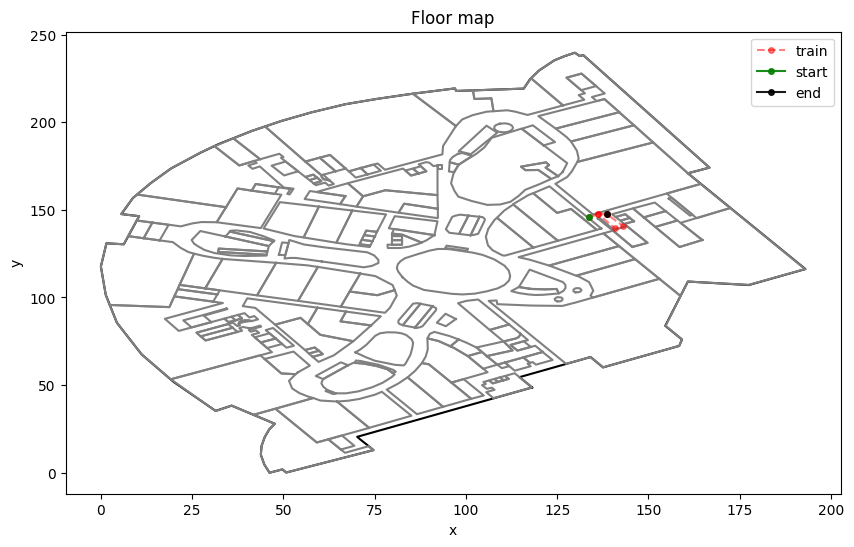

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])

plot_waypoint_location(waypoint_location, ax=ax, plot_kwargs={"label": "train", "ls": "--"})

ax.legend()
plt.ticklabel_format(useOffset=False)
plt.show()

In [14]:
magn_df = pd.DataFrame(path_datas.magn, columns=["ts", "magn_x", "magn_y", "magn_z"])
acce_df = pd.DataFrame(path_datas.acce, columns=["ts", "acce_x", "acce_y", "acce_z"])
sensor_df = pd.merge(acce_df, magn_df, how="outer")
sensor_df.ffill(inplace=True)
sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
sensor_df.sort_values("ts", ascending=True, inplace=True)

In [15]:
acce_n, headings_n = estimate_acceleration_heading(acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
                                                   magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)

In [16]:
acce_n_ts = np.zeros([len(acce_n), 4])
acce_n_ts[:, 1:] = acce_n
acce_n_ts[:, 0] = sensor_df["ts"].values

In [17]:
headings_n_ts = np.zeros((len(headings_n), 2))
headings_n_ts[:, 0] = sensor_df["ts"].values
headings_n_ts[:, 1] = np.radians(headings_n)

In [18]:
step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_n_ts)
stride_lengths = compute_stride_length(step_acce_max_mins)
step_headings = compute_step_heading(step_timestamps, headings_n_ts)
rel_positions = compute_rel_positions(stride_lengths, step_headings)
step_positions = correct_positions(rel_positions, path_datas.waypoint)

In [19]:
turn_point_mask = detect_turn_points(filter_headings(step_headings[:, 1]))

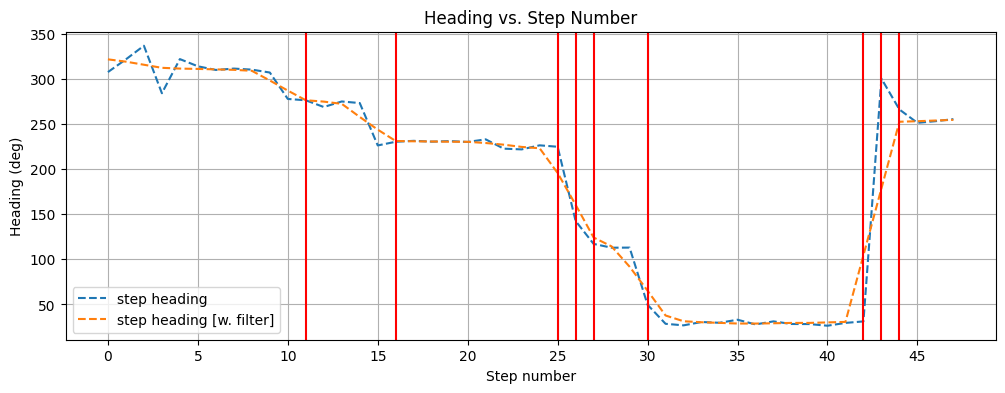

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(np.degrees(step_headings[:, 1]), label="step heading", ls="--")
ax.plot(np.degrees(filter_headings(step_headings[:, 1])), label="step heading [w. filter]", ls="--")

for x in np.where(turn_point_mask)[0]:
  ax.axvline(x=x, color="red")

ax.legend()
ax.grid()
ax.set_xlabel("Step number")
ax.set_ylabel("Heading (deg)")
ax.set_title("Heading vs. Step Number")
ax.set_xticks(range(0, len(step_headings), 5))

plt.show()

In [21]:
len(turn_point_mask)

48

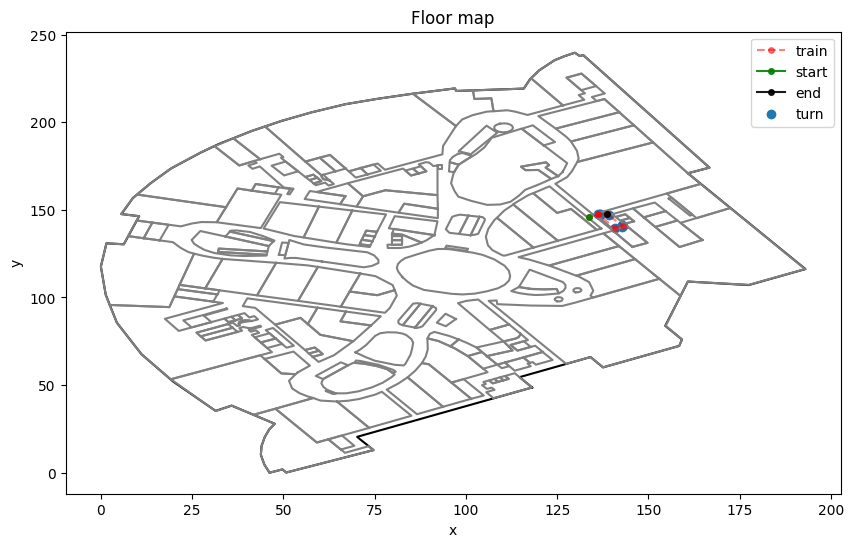

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])

plot_waypoint_location(waypoint_location, ax=ax, plot_kwargs={"label": "train", "ls": "--"})
ax.scatter(step_positions[turn_point_mask, 1], step_positions[turn_point_mask, 2], label="turn")

ax.legend()
plt.ticklabel_format(useOffset=False)
plt.show()

## Signal Data

In [24]:
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set, create_fingerprint_vector

In [25]:
def create_wifi_df(wifi: np.ndarray, max_time_offset_ms: int = 1000) -> pd.DataFrame:
  wifi_df = pd.DataFrame(wifi, columns=["sys_ts", "ssid", "bssid", "rssi", "freq", "last_seen_ts"])

  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.float32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  wifi_df = wifi_df[(wifi_df["sys_ts"] - wifi_df["last_seen_ts"] <= max_time_offset_ms) &
                    (wifi_df["sys_ts"] > wifi_df["last_seen_ts"])]

  return wifi_df

In [26]:
path_data_list = [read_data_file(data_file) for data_file in data_files]

In [27]:
wifi_df_list = [create_wifi_df(path_data.wifi) for path_data in path_data_list]

In [28]:
bssid_set = extract_bssid_set(wifi_df_list)
bssid_vector = np.array(list(bssid_set))

In [29]:
def create_fingerprint_df(wifi_df: pd.DataFrame, 
                          bssid_vector: np.ndarray, 
                          ap_not_seen_rssi: float = -100):
  fingerprint_tuples = []

  for (sys_ts,), group_data in wifi_df.groupby(["sys_ts"]):
    fingerprint_vector = create_fingerprint_vector(
      group_data, bssid_vector, ap_not_seen_rss=ap_not_seen_rssi)
    fingerprint_tuples.append((sys_ts, fingerprint_vector))

  fingerprint_df = pd.DataFrame(fingerprint_tuples, columns=["sys_ts", "v"])
  fingerprint_df.sort_values("sys_ts", inplace=True)
  fingerprint_df.reset_index(drop=True, inplace=True)

  return fingerprint_df

In [30]:
fingerprint_df = create_fingerprint_df(wifi_df_list[0], bssid_vector=bssid_vector)

In [31]:
F = np.vstack(fingerprint_df["v"].values.tolist())

In [32]:
F

array([[-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       ...,
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.],
       [-100., -100., -100., ..., -100., -100., -100.]], dtype=float32)

In [33]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False) -> pd.DataFrame:
  """
  Waypoint data extraction and cleaning.
  """

  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [34]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [36]:
from compute_f import compute_step_positions

In [37]:
def to_text(v: np.ndarray, sep: str = ","):
  return sep.join([str(vv) for vv in v])


def to_array(v_text: str, sep: str = ",") -> np.ndarray:
  return np.array([float(vv) for vv in v_text.split(sep)], dtype=np.float32)

In [39]:
!mkdir -p ../../data/wifi_location/{site_id}/{floor_id}

In [40]:
for i, data_file in tqdm(enumerate(data_files), desc="Progress"):
  track_id = os.path.basename(data_file[:-len(".txt")])

  path_datas = read_data_file(data_file)
  step_positions = compute_step_positions(path_datas.acce, path_datas.ahrs, path_datas.waypoint)
  step_waypoint_df = extract_waypoint_df(step_positions)
  
  wifi_df = wifi_df_list[i]
  fingerprint_df = create_fingerprint_df(wifi_df, bssid_vector=bssid_vector)
  
  wifi_location_df = interpolate_wifi_waypoints(step_waypoint_df, fingerprint_df)
  wifi_fingerprint_location_df = pd.merge(fingerprint_df, wifi_location_df, left_on="sys_ts", right_on="sys_ts")
  
  wifi_fingerprint_df_write = wifi_fingerprint_location_df.copy()
  wifi_fingerprint_df_write["v"] = wifi_fingerprint_df_write["v"].apply(to_text)

  wifi_fingerprint_df_write.to_csv(f"../../data/wifi_location/{site_id}/{floor_id}/{track_id}.csv",
                                   sep="|", index=False)


Progress: 132it [01:07,  1.95it/s]


In [42]:
with open(f"../../data/wifi_location/{site_id}/{floor_id}/bssid.txt", "w") as f:
  f.write("\n".join(bssid_vector.tolist()))
  f.write("\n")

In [192]:
wifi_fingerprint_df_write.to_csv(f"../../data/wifi_location/{site_id}/{floor_id}/{track_id}.csv",
                           sep="|",
                           index=False)

In [211]:
wifi_fingerprint_location_df = pd.read_csv(f"../../data/wifi_location/{site_id}/{floor_id}/{track_id}.csv", sep="|",)

In [212]:
wifi_fingerprint_location_df["v"] = wifi_fingerprint_location_df["v"].apply(lambda vv: to_array(vv, sep=","))

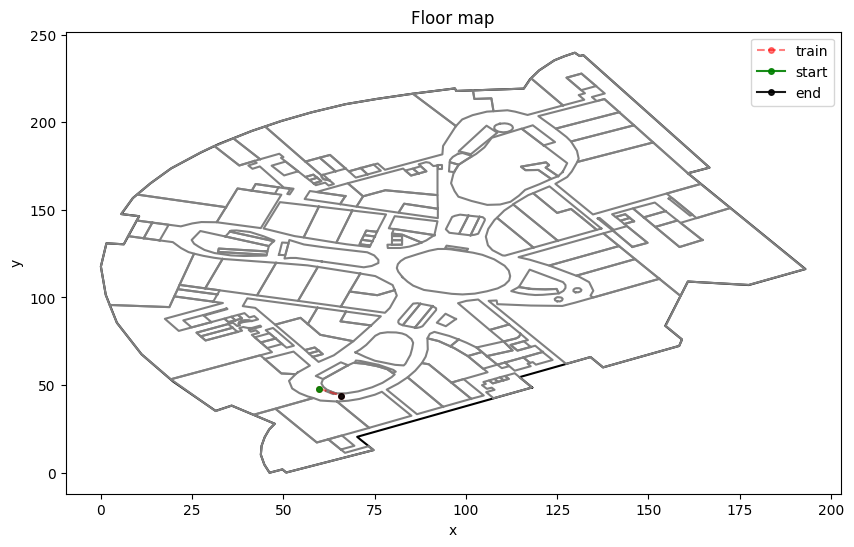

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])

plot_waypoint_location(waypoint_location, ax=ax, plot_kwargs={"label": "train", "ls": "--"})

ax.legend()
plt.ticklabel_format(useOffset=False)
plt.show()